# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.utils import resample

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 21.0MB/s]
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


# Describe Dataset

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Replace zeroes with null

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

## Histogram BEFORE cleaning

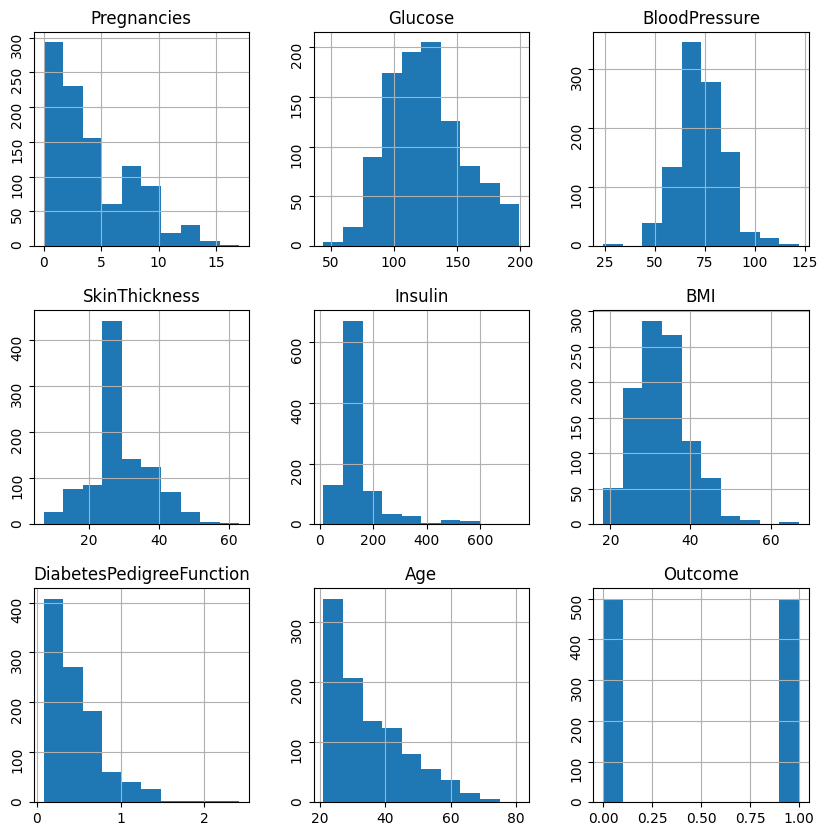

In [ ]:
p = df.hist(figsize = (10,10), yrot=90)

# Data Cleaning

## Replace null with mean

In [ ]:
glucose_mean = df['Glucose'].mean(axis = 0, skipna = True)
blood_mean = df['BloodPressure'].mean(axis = 0, skipna = True)
skin_mean = df['SkinThickness'].mean(axis = 0, skipna = True)
insulin_mean = df['Insulin'].mean(axis = 0, skipna = True)
bmi_mean = df['BMI'].mean(axis = 0, skipna = True)

In [ ]:
print(glucose_mean)
print(blood_mean)
print(skin_mean)
print(insulin_mean)
print(bmi_mean)

121.6867627785059
72.40518417462484
29.153419593345657
155.5482233502538
32.457463672391015


In [ ]:
df["Glucose"] = df["Glucose"].apply(lambda x: glucose_mean if pd.isnull(x) else x)
df["BloodPressure"] = df["BloodPressure"].apply(lambda x: blood_mean if pd.isnull(x) else x)
df["SkinThickness"] = df["SkinThickness"].apply(lambda x: skin_mean if pd.isnull(x) else x)
df["Insulin"] = df["Insulin"].apply(lambda x: insulin_mean if pd.isnull(x) else x)
df["BMI"] = df["BMI"].apply(lambda x: bmi_mean if pd.isnull(x) else x)

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.00000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.00000,155.548223,36.8,0.340,27,0
765,5,121.0,72.0,23.00000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,29.15342,155.548223,30.1,0.349,47,1


## Upscaling the "outcome" feature

0    500
1    268
Name: Outcome, dtype: int64

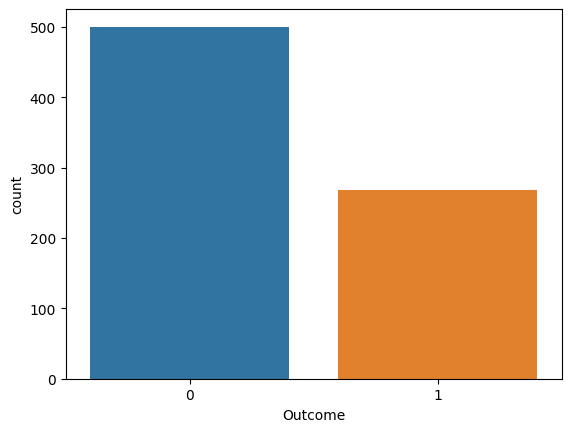

In [ ]:
sns.countplot(x = df['Outcome'])
df['Outcome'].value_counts()

In [ ]:
data_major = df[(df['Outcome']==0)]
data_minor = df[(df['Outcome']==1)]
upsample = resample(data_minor, replace = True, n_samples = 500, random_state= 42)
df = pd.concat([upsample, data_major])

1    500
0    500
Name: Outcome, dtype: int64

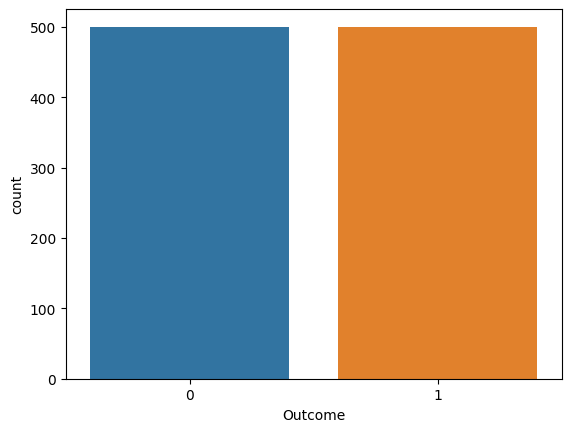

In [ ]:
sns.countplot(x = df['Outcome'])
df['Outcome'].value_counts()

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,4.191000,124.919121,73.321828,29.687333,161.300371,32.813532,0.476622,34.273000,0.50000
std,3.566685,29.710588,11.969096,8.323038,85.559825,6.764961,0.327363,11.623751,0.50025
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.00000
25%,1.000000,103.000000,66.000000,27.000000,135.000000,28.000000,0.246750,25.000000,0.00000
50%,3.000000,122.000000,72.405184,29.153420,155.548223,32.457464,0.370000,31.000000,0.50000
75%,7.000000,144.000000,80.000000,33.000000,155.548223,36.600000,0.645250,42.000000,1.00000
max,17.000000,199.000000,122.000000,63.000000,744.000000,67.100000,2.420000,81.000000,1.00000


## Histogram AFTER cleaning

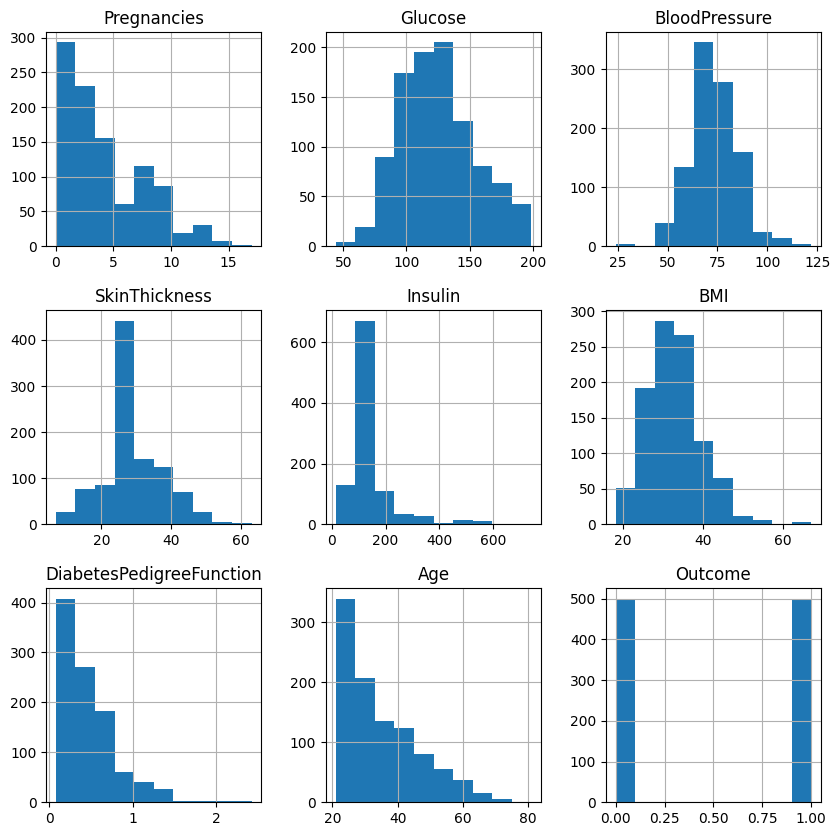

In [ ]:
p = df.hist(figsize = (10,10))

# Modeling

In [ ]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Machine Learning Models

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3) # both 2 and 3 has the same accuracy 0.8
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)

print('KNN Accuracy:', knn_acc)
print(classification_report(y_test, knn_pred))

KNN Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       104
           1       0.77      0.83      0.80        96

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



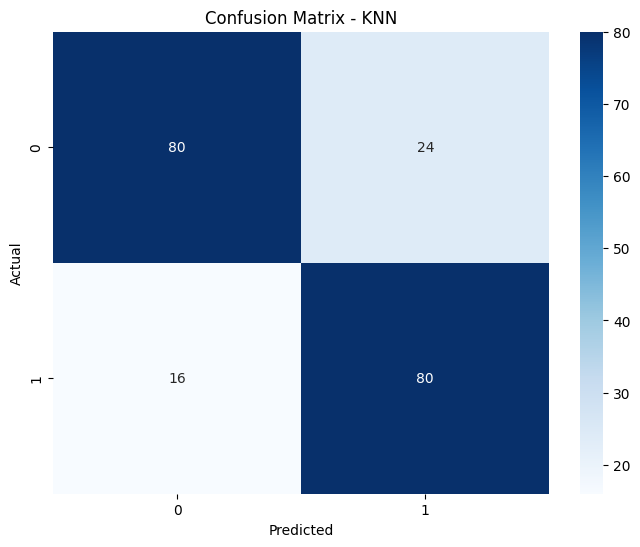

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion = confusion_matrix(y_test, knn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)

print('XGBoost Accuracy:', xgb_acc)
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       104
           1       0.81      0.93      0.86        96

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



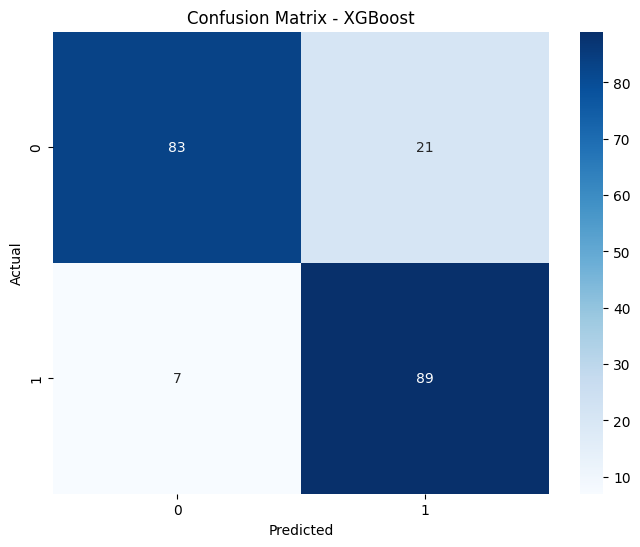

In [ ]:
confusion = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print('Random Forest Accuracy:', rf_acc)
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.895
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       104
           1       0.84      0.97      0.90        96

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



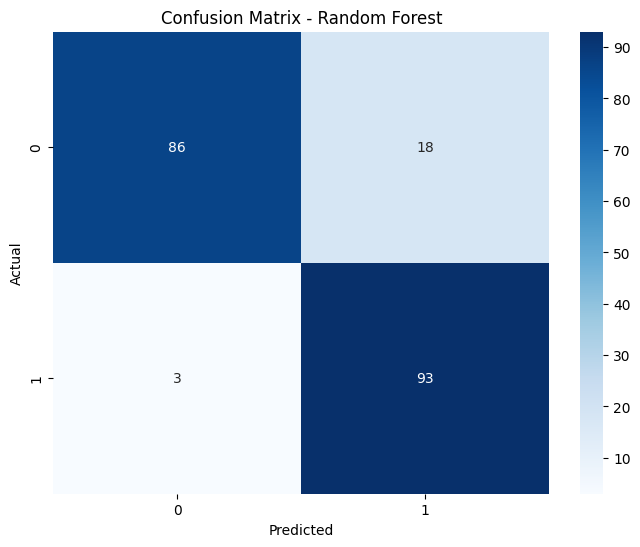

In [ ]:
confusion = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### SVM

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

print('SVM Accuracy:', svm_acc)
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       104
           1       0.75      0.84      0.79        96

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.80      0.79      0.79       200



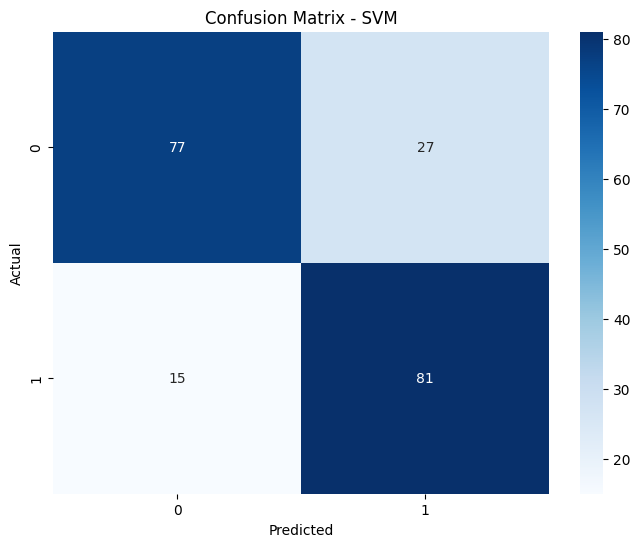

In [ ]:
confusion = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()